# framework RACC

Ce framework a pour objectif de mettre en place une estimation de la pluie à partir de données MO (SSMIS) et IR (Meteosat)
Les changements à faire dans le code sont marqués par le mot clé TODO

## imports

In [1]:
# reloading 
%load_ext autoreload
%autoreload 2

# importing librairies
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta
from scipy.stats import pearsonr, spearmanr
from scipy.interpolate import interp1d, Rbf
from scipy.optimize import curve_fit

import json
import glob
import sys
import warnings
import os

# importing modules from pluie directory
from classification import classification
import ground_truth as gt

# importing modules from Images
sys.path.insert(0, r'../Images')
from Image import Image
from File import File
from Geotiff_Format import Geotiff_Format

# importing meteosat API modules
sys.path.insert(0, r'API_meteosat')
from eds_get_nearest import search_nearest,download_dataset
sys.path.insert(0, r'API_nsidc')
from SSMIS_download import download_Meteosat_images

## Initialisation des variables principales

On définit les chemins d'accès principaux afin d'obtenir les variables utiles dans tout le code

In [76]:
def get_index(index_path):
    with open(index_path, "r", encoding="utf-8") as json_dict:
        index = json.load(json_dict)
    return index
    
def save_index(index,index_path):
    with open(index_path, 'w', encoding="utf-8") as json_dict:
        json.dump(index, json_dict, indent=4, default=str)
        
def make_directory(path):
    if not os.path.exists(path):
        os.makedirs(path)
    return path

In [85]:
# TODO : remplir le chemin d'accès au dossier principal où tous les fichiers seront générés
main_dir = make_directory(r"../../data/RACC/mai_2020")

# TODO : remplir le chemin d'accès au fichier json contenant les dates et leurs différents attributs
index_path = main_dir + r"/acq_dates.json"

# TODO : remplir le chemin d'accès au fichier json contenant les paramètres de la projection comme la résolution et l'emprise
projection_path = r"../../data/param_proj/param_guy.json"

# TODO : remplir le chemin d'accès aux fichiers csv contenant la vérité terrain
gt_fn = r"../../data/pluie_sol/gg_05-20_1h.csv"
mtd_fn = r"../../data/pluie_sol/gauges_guyane_metadata.csv"

# TODO : compléter les dates visées dans le format suivant
target_dates = [
    "2020-05-03T12:00:00.000000+0000",
    "2020-05-15T12:00:00.000000+0000",
    "2020-05-18T12:00:00.000000+0000",
    "2020-05-24T12:00:00.000000+0000",
    "2020-05-29T12:00:00.000000+0000"
]

target_dates = [
    "2020-05-03T12:00:00.000000+0000",
    "2020-05-08T12:00:00.000000+0000",
    "2020-05-11T12:00:00.000000+0000",
    "2020-05-15T12:00:00.000000+0000",
    "2020-05-18T12:00:00.000000+0000",
    "2020-05-24T12:00:00.000000+0000",
    "2020-05-26T12:00:00.000000+0000",
    "2020-05-29T12:00:00.000000+0000"
]

# TODO : remplir le chemin d'accès aux dossiers où seront téléchargés les fichiers bruts
SSMIS_src_dir = make_directory(r"../../data/SSMI/download_dec_2020")
SEVIRI_src_dir = make_directory(r"../../data/SEVIRI/dec_2020")

###########################################

SSMIS_proj_dir = make_directory(main_dir + r"/SSMIS")
SEVIRI_proj_dir = make_directory(main_dir + r"/SEVIRI")
out_dir = make_directory(main_dir + r"/rain_rate")
agr_dir = make_directory(main_dir + r"/agregation")
seg_dir = make_directory(main_dir + r"/classification")

projection = json.load(open(projection_path, "r", encoding="utf-8"))
format = "%Y-%m-%dT%H:%M:%S.%f%z"

index = {d.split(" ")[0]:{"target":d} for d in target_dates}
#index = {}
save_index(index,index_path)   # peut supprimer un fichier courant

## Extraction des images SSMIS 

In [79]:
def download_SSMIS(index_path, SSMIS_src_dir, SSMIS_proj_dir, attribute, projection, research_parameters):
    index = get_index(index_path)
    for d in index.keys():
        # téléchargement des données
        retour = download_Meteosat_images(d,SSMIS_src_dir,projection,research_parameters)
        tg_freq = research_parameters["freq"][0]
        if retour:
            src_filename,start_date,end_date = retour
            file = File(src_filename) ; string_d = d[:10]
            tif_filename = SSMIS_proj_dir + rf"/SSMIS_{attribute}_{tg_freq}_{string_d}.tiff"
            file.project(projection,attribute,out_path=tif_filename)

            index[d][f"SSMIS_src_{tg_freq}"] = src_filename
            index[d][f"start_date_{tg_freq}"] = datetime.strftime(start_date,format)
            index[d][f"end_date_{tg_freq}"] = datetime.strftime(end_date,format)
            index[d][f"SSMIS_tif_{tg_freq}"] = tif_filename
            save_index(index,index_path)
        else:
            print(f"aucun fichier n'a été trouvé pour la date {d}")
        

In [ ]:
research_parameters = {
        "freq":["91V","91V","91V","91V"],
        "passage":["E","A","E","A"],
        "capteur":["F17_SSMIS","F17_SSMIS","F16_SSMIS","F16_SSMIS"],
        "algo":["GRD","GRD","GRD","GRD"],
        "grid":["N25km","N25km","N25km","N25km"]
        }
download_SSMIS(index_path, SSMIS_src_dir, SSMIS_proj_dir, "TB", projection, research_parameters)

## Extraction des images SEVIRI

In [89]:
def download_SEVIRI(    index_path, 
                        SEVIRI_src_dir, 
                        path_API_keys = r"../../data/keys/eds.key",
                        nb_files_per_period=12,
                        format="%Y-%m-%dT%H:%M:%S.%f%z"):

    zipped_dir,unzipped_dir = make_directory(SEVIRI_src_dir+r"/zipped"),make_directory(SEVIRI_src_dir+r"/unzipped")

    index = get_index(index_path)
    prod_list = []
    for d in index.keys():
        print(f"recherche pour la date {d}")
        
        index[d]["Meteosat_imgs"] = {}
        try :
            start_acq_date = datetime.strptime(index[d]["start_date_91V"],format)
            end_acq_date = datetime.strptime(index[d]["end_date_91V"],format)
        except:
            print(f"aucun fichier a été trouvé pour la date {d}")
            pass
        delta = timedelta(seconds=(end_acq_date - start_acq_date).total_seconds() / nb_files_per_period)
        researched_dates = [start_acq_date + i*delta for i in range(nb_files_per_period)]
        
        for i in range(len(researched_dates)):
            res_d = researched_dates[i]
            print(res_d)
            prod, Meteosat_date = search_nearest(res_d)
            
            filename = fr"{unzipped_dir}/{prod}.nat"
            index[d]["Meteosat_imgs"][i] = {    "file": filename,
                                                "date": datetime.strftime(Meteosat_date,format)}
            if os.path.exists(filename):
                print(f"le fichier {filename} a déjà été téléchargé")
            else:
                prod_list.append(prod)
            
          
    print(f"téléchargement de {len(prod_list)} images")
    download_dataset(prod_list,zipped_dir,unzipped_dir,path_API_keys)
    save_index(index,index_path)
    


def prepare_SEVIRI_images(index_path, out_dir, attribute, projection):
    """
    prépare les images SEVIRI en réalisant leur extraction, leur projection et leur agrégation

    Args : 
        index_path (string) : chemin d'accès au fichier json contenant les informations sur les fichiers images
        out_dir (string) : chemin vers le dossier où enregistrer les images
        attribute (string) : attribut à extraire
        projection (dict) : dictionnaire contenant les paramètres de projection, notamment l'emprise 

    "Meteosat_imgs": {
            "0": {
                "file": "../../data/SEVIRI/dec_2020/unzipped/MSG4-SEVI-MSG15-0100-NA-20201201171243.037000000Z-NA.nat",
                "date": "2020-12-01T17:12:43.000000+0000"
            },...
        }
    """
    index = get_index(index_path)
    for d in index.keys():
        images_dict = index[d]["Meteosat_imgs"]
        arrays_SEVIRI_d = []
        print(f"date:{d}")
        for img_idx in images_dict.keys():
            print(img_idx)
            try:
                SEVIRI_file = File(images_dict[img_idx]["file"])
                img_proj = SEVIRI_file.project(projection,attribute)
                arrays_SEVIRI_d.append(img_proj.array)
            except FileNotFoundError :
                print(f"le fichier {SEVIRI_file.path} n'a pas été trouvé")
                pass
        img_proj_agreg = Image(np.mean(np.array(arrays_SEVIRI_d),axis=0),img_proj.lons,img_proj.lats)
        filename = out_dir + rf"/TB_SEVIRI_{attribute}_{d[:10]}.tiff"
        img_proj_agreg.save(projection,filename)
        index[d][f"SEVIRI_{attribute}_tif"] = filename
    save_index(index,index_path)
        

In [92]:
#download_SEVIRI(index_path,SEVIRI_src_dir,nb_files_per_period=8,format=format)
#prepare_SEVIRI_images(index_path, SEVIRI_proj_dir, "IR_108", projection)


for band in ["IR_039","WV_062","WV_073","IR_087","IR_097","IR_108","IR_120","IR_134","HRV"]:
    prepare_SEVIRI_images(index_path, SEVIRI_proj_dir, band, projection)

    


date:2020-05-03T12:00:00.000000+0000
0
le fichier ../../data/SEVIRI/dec_2020/unzipped/MSG4-SEVI-MSG15-0100-NA-20200502021243.115000000Z-NA.nat n'a pas été trouvé
1
le fichier ../../data/SEVIRI/dec_2020/unzipped/MSG4-SEVI-MSG15-0100-NA-20200502054242.309000000Z-NA.nat n'a pas été trouvé
2
le fichier ../../data/SEVIRI/dec_2020/unzipped/MSG4-SEVI-MSG15-0100-NA-20200502091243.479000000Z-NA.nat n'a pas été trouvé
3
le fichier ../../data/SEVIRI/dec_2020/unzipped/MSG4-SEVI-MSG15-0100-NA-20200502125742.962000000Z-NA.nat n'a pas été trouvé
4
le fichier ../../data/SEVIRI/dec_2020/unzipped/MSG4-SEVI-MSG15-0100-NA-20200502162742.615000000Z-NA.nat n'a pas été trouvé
5
le fichier ../../data/SEVIRI/dec_2020/unzipped/MSG4-SEVI-MSG15-0100-NA-20200502195742.385000000Z-NA.nat n'a pas été trouvé
6
le fichier ../../data/SEVIRI/dec_2020/unzipped/MSG4-SEVI-MSG15-0100-NA-20200502234242.285000000Z-NA.nat n'a pas été trouvé
7
date:2020-05-08T12:00:00.000000+0000
0
1
2
3
4
5
6
7
date:2020-05-11T12:00:00.000000+0

KeyboardInterrupt: 

## Relation images - vérité terrain

In [4]:
def combine_image_with_GT(index_path,path_GT,path_metadata_GT,key,projection,attribute=1,start_date_key="start_date",end_date_key="end_date",format="%Y-%m-%dT%H:%M:%S.%f%z"):
   
    # récupération des fichiers
    gt_dict = gt.csv2dict(path_GT)[0]
    metadata_gt = gt.get_metadata(path_metadata_GT)
    index = get_index(index_path)
    
    # initialisation des listes contenant les données
    pixel_values, true_rain, locations = [], [], []
    for d in index.keys():
        try:
            file = File(index[d][key])
            img = file.project(projection,attribute)
            start_date = datetime.strptime(index[d][start_date_key],format)
            end_date = datetime.strptime(index[d][end_date_key],format)
            gt_extr_dict = gt.extract(gt_dict,start_date,end_date)
            gt_agr_dict = gt.agreg(gt_extr_dict,method="mean")
            agr_gt = np.array([gt_agr_dict[d] for d in gt_agr_dict.keys()])
            for k in metadata_gt.keys():
                lat, lon = float(metadata_gt[k]["lat"]),float(metadata_gt[k]["lon"])
                lats, lons = img.lats.T[0], img.lons[0]
                idx_lat,idx_lon = (np.abs(lats - lat)).argmin(), (np.abs(lons - lon)).argmin()
                estimated_rain = img.array[idx_lat][idx_lon]
                if not np.isnan(estimated_rain):
                    true_rain.append(agr_gt[0][k-1])
                    pixel_values.append(estimated_rain)
                    locations.append(metadata_gt[k]["Nom"])
                    
        except KeyError:
            print(f"le fichier correspondant à la date {d} n'a pas été trouvé pour la clé {key}")
            true_rain.append(np.NaN)
            pixel_values.append(np.NaN)
            locations.append(np.NaN)
    
    return true_rain,pixel_values,locations

In [5]:
def f_model(x,x_lim,a,b):
    return np.where(x>x_lim,0,a*x+b)
    #return a*np.exp(b*x)+c

def fit_model(key,index_path,gt_fn,mtd_fn,projection,sdk="start_date_91V",edk="end_date_91V",plot=True):
    rain_gt,val_images,locations = combine_image_with_GT(index_path,gt_fn,mtd_fn,key,projection,end_date_key=edk,start_date_key=sdk)
    xdata,ydata = [],[]
    for i in range(len(rain_gt)):
        if (not np.isnan(val_images[i])) and (not np.isnan(rain_gt[i])) :
            xdata.append(val_images[i]) ; ydata.append(rain_gt[i])
    xlim = np.max(xdata)
    a = (xdata[0]-xdata[1])/(ydata[0]-ydata[1])
    b = ydata[0] - a*xdata[0]
    param_opt, pcov = curve_fit(f=f_model,xdata=xdata,ydata=ydata,p0=(xlim,a,b))

    if plot:
        [x_lim,a,b] = param_opt
        xsample = np.linspace(230, 300, 100)
        ysample = [f_model(xsample[i],x_lim,a,b) for i in range(len(xsample))]

        plt.plot(xsample,ysample,color="red")
        plt.scatter(xdata,ydata)
        plt.ylim(ymin=np.min(ydata)-1,ymax=np.max(ydata)+1)
        plt.show()

    return param_opt

def compute_rain_rate(index_path,out_dir,param_opt,projection,key):
    index = get_index(index_path)
    [x_lim,a,b] = param_opt
    for d in index.keys(): # récupération des images
        try:
            image = File(index[d][key]).getImage(1)
            image_values = np.where(image.array==0,np.NaN,image.array)
            R = f_model(image_values,x_lim,a,b)
            img_rain_rate = Image(R,image.lons,image.lats)
            filename = out_dir + rf"/rain_rate_{d[:10]}.tiff"
            img_rain_rate.save(projection,filename)
            index[d]["rain_rate"] = filename
            save_index(index,index_path)
        except KeyError:
            print(f"l'un des fichiers correspondant à la date {d} n'a pas été trouvé")



../../data/pluie_sol/gg_05-20_1h.csv
768 lignes ont été écartées, il s'agit probablement de lignes vides
-0.2985172645718444 85.54965465785459 287.24


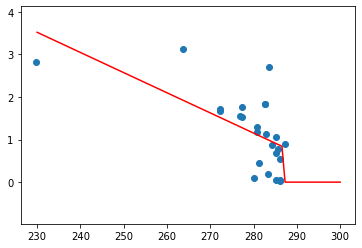

[ 2.87239990e+02 -4.73682132e-02  1.44160255e+01]


In [118]:
key="SSMIS_tif_91V"

param_opt=fit_model(key,index_path,gt_fn,mtd_fn,projection,sdk="start_date_91V",edk="end_date_91V")
compute_rain_rate(index_path,out_dir,param_opt,projection,key)

## Agrégation des données

In [143]:
def agregation_geotiff(index_path,out_dir,key,mode="mean",compute_var=False):
    arrays = []
    index = get_index(index_path)
    for d in index.keys(): # récupération des images
        try:
            file = File(index[d][key])
            if file.format != Geotiff_Format:
                print("le fichier doit être en format Geotiff")
                raise
            img = file.getImage(1)
            arrays.append(img.array)
        except KeyError:
            print(f"le fichier correspondant à la date {d} n'a pas été trouvé pour la clé {key}")
    
    lons,lats = img.lons, img.lats
    if mode == "mean":
        output = np.nanmean(np.array(arrays),axis=0)
    else:
        output = np.sum(np.array(arrays),axis=0)
    img_output = Image(output, lons, lats)
    img_output.save(projection,out_dir + rf"/{key}_agreg.tiff")
    if compute_var:
        img_output_var = img_output.computeVar()
        img_output_var.save(projection,out_dir + rf"/{key}_agreg_var.tiff")


In [7]:
#key = "SSMIS_tif_91V" ; var = False
key = "SEVIRI_IR_108_tif" ; var = True
#key = "rain_rate" ; var = False
#agregation_geotiff(index_path,agr_dir,key,compute_var=var)

## Méthode RACC

classification des images en entrée à partir de la méthode des K-means

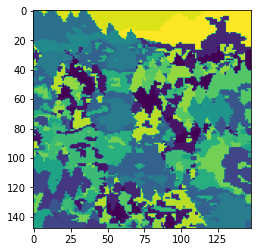

../../data/pluie_sol/gg_05-20_1h.csv
768 lignes ont été écartées, il s'agit probablement de lignes vides


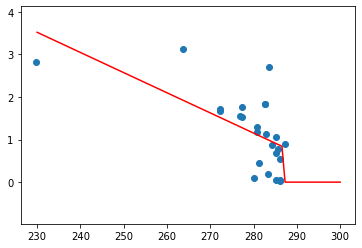

[[264.31427      0.68040794 275.2264       1.3790417 ]
 [260.7696       0.8400715  278.15976      1.2400942 ]
 [268.06522      0.7234624  279.7792       1.1633844 ]
 [253.2995       0.6811333  272.1861       1.523056  ]
 [248.41397      0.9521208  282.24448      1.0466089 ]
 [258.32794      0.79537576 266.9184       1.7725773 ]
 [261.9261       0.7724811  283.19662      1.0015068 ]
 [275.5537       0.4371769  285.7353       0.88125515]
 [265.73145      0.76503026 284.0697       0.9601507 ]
 [271.72867      0.82551014 285.22653      0.90535355]
 [258.80026      0.8965641  258.71143      2.1613274 ]
 [251.16385      0.633578   275.96045      1.3442717 ]
 [258.91013      0.8076667  282.5892       1.0302792 ]
 [256.76663      0.8801053  277.74063      1.2599478 ]
 [262.588        0.6501475  270.18323      1.6179285 ]
 [254.52013      1.0197374  282.903        1.0154152 ]
 [260.128        0.87774074 273.58005      1.4570274 ]
 [264.141        0.7384241  279.55682      1.1739178 ]
 [277.7854

In [11]:
N = 20 ; key="SSMIS_tif_91V"

array_pred,centers = classification(agr_dir,seg_dir,projection,N=N,epsilon=0.001,T=100)

[x_lim,a,b]=fit_model(key,index_path,gt_fn,mtd_fn,projection)
rain_rate = f_model(centers.T[2],x_lim,a,b)
centers = np.concatenate((centers, rain_rate.reshape(N,1)), axis=1)
print(centers)


## Corrélation

In [81]:
def correlation(list1,list2,attributes=False,indice_corr="Pearson",savefig=False,param_opt=False):
    xmin,xmax = 260,290
    if indice_corr == "Pearson":
        corr, _ = pearsonr(list1, list2)
    elif indice_corr == "Spearman":
        corr, _ = spearmanr(list1, list2)

    print(f"indice de corrélation de {indice_corr}: {round(corr,3)}")

    if attributes:
        color_list = ["red","green","blue","orange","yellow","pink","black","purple","beige","brown","gray","cyan"]
        colors = [color_list[np.where(np.unique(attributes)==loc)[0][0]] for loc in attributes]
        plt.scatter(list1,list2,c=colors,s=60, alpha=0.8)
        for i in range(len(np.unique(attributes))):
            print(color_list[i],"\t",np.unique(attributes)[i])
    else:
        plt.scatter(list1,list2,s=60,alpha=0.8)
    plt.grid()
    plt.title(f"mesures en mai 2022, corrélation = {round(corr,3)}")
    plt.xlabel("pluviommétrie moyenne (mm/h)")
    plt.ylabel("TB SEVIRI IR 0.97 µm (K)")
    #plt.xlim(xmin=xmin,xmax=xmax)
    try:
        [x_lim,a,b] = param_opt
        xsample = np.linspace(xmin, xmax, 100)
        ysample = [f_model(xsample[i],x_lim,a,b) for i in range(len(xsample))]
        plt.plot(xsample,ysample,c="red")
    except TypeError:
        pass
    if savefig:
        plt.savefig(savefig, dpi=500)
    plt.show()

../../data/pluie_sol/gg_05-20_1h.csv
768 lignes ont été écartées, il s'agit probablement de lignes vides
../../data/pluie_sol/gg_05-20_1h.csv
768 lignes ont été écartées, il s'agit probablement de lignes vides
40
indice de corrélation de Spearman: -0.456


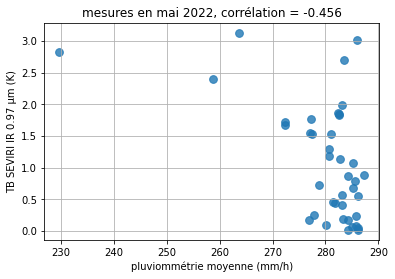

In [88]:
savefig = r"../../rapports/images/rel_TBIR097-rain_0520.png"

#SEVIRI_IR_097_tif - SSMIS_tif_91V
key,sdk,edk = "SSMIS_tif_91V","start_date_91V","end_date_91V"
param_opt=fit_model(key,index_path,gt_fn,mtd_fn,projection,plot=False)

#for band in ["IR_039","WV_062","WV_073","IR_087","IR_097","IR_108","IR_120","IR_134","HRV"]:
#key = f"SEVIRI_{band}_tif"

true_rain,estim_rain,locations = combine_image_with_GT(index_path,gt_fn,mtd_fn,key,projection,end_date_key=edk,start_date_key=sdk)

A,B,attributes = [],[],[]
for i in range(len(true_rain)):
    if (not np.isnan(true_rain[i]) and (not estim_rain[i]==0)):
        A.append(estim_rain[i])
        B.append(true_rain[i])
        attributes.append(locations[i])
print(len(A))
correlation(A,B,indice_corr="Spearman",savefig=False,param_opt=False)
